In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [2]:
from utils import dataset_CDD_CESM, patient_CDD

# Lesions to use

We must define the bbox of the lesions to detect using the DBT model framework.

Key works to remove:
- Non enhancement
    - Nov visible lesion, not including
- Focus enhancement
    - There are regions with very weak enhancement, should we include them? E.g.: Pat18
- Rim enhancement
    - Should we include them? They have an inverse intensity to usual lesions (black instead of white)

Problems:
- Images with multiple lesions, which one to pick?
    - All?
    - Largest?
    - Accept satelite lesions?
- Irregular shapes, speculated masses, etc.
    - shoudl the Bbox include the whole annotated area?

- Ill defined lesions:
    - Redifine the annotation. Possible largest bbox?



In [17]:
mode = 'substracted'
dataset_CESM = dataset_CDD_CESM(mode=mode)
print(dataset_CESM)

excluding_list = ['non enhancement', 'focus enhancement', 'rim enhancement']

# exclude cases with 'non mass' tags
meta_filterd = dataset_CESM.metadata[~dataset_CESM.metadata['Tags'].str.contains('non mass', case=False)]
for case in excluding_list:
    meta_filterd = meta_filterd[~meta_filterd['Findings'].str.contains(case, case=False)]

# filter to keep only casses with word 'mass' in the tags
meta_filterd = meta_filterd[meta_filterd['Tags'].str.contains('mass')]
print(meta_filterd['Pathology Classification/ Follow up'].value_counts().to_string())
mass_patients = meta_filterd['Patient_ID'].unique()
print(f'Number of patients with mass: {len(mass_patients)}')
dataset_CESM.redefine_metadata(meta_filterd)

CDD-CESM dataset with 326 patients
Total images: 1003
Pathology Classification/ Follow up
Malignant    204
Benign        41
Number of patients with mass: 132


In [23]:
pat_id = dataset_CESM.patient_ids[29]
patient = patient_CDD(pat_id, dataset_CESM)
print(patient)


Patient 114 with 2 images


Image 2 of 2
End of patient's images, reseting counter to 0


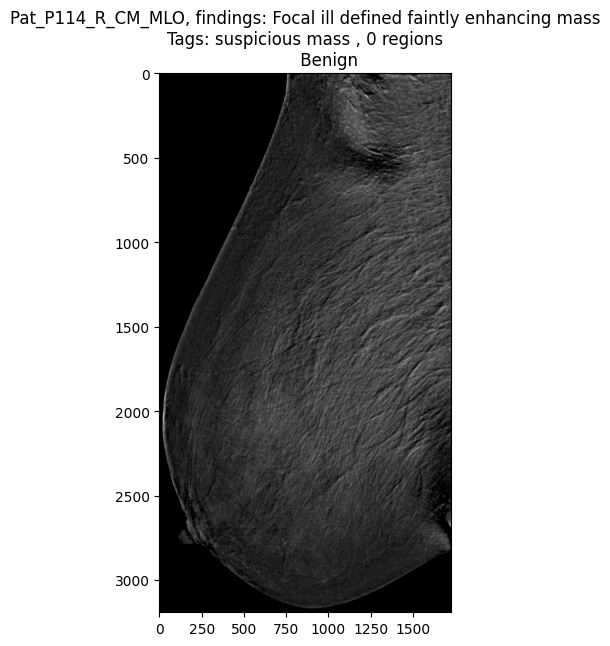

In [25]:
patient.set_image()
im_array = patient.get_array(plot=False)
patient.plot_annotations()

# Obtain bounding boxes of lesions

In [5]:
mode = 'substracted'
dataset_CESM = dataset_CDD_CESM(mode=mode)
print(dataset_CESM)

excluding_list = ['non enhancement', 'focus enhancement', 'rim enhancement']

# exclude cases with 'non mass' tags
meta_filterd = dataset_CESM.metadata[~dataset_CESM.metadata['Tags'].str.contains('non mass', case=False)]
for case in excluding_list:
    meta_filterd = meta_filterd[~meta_filterd['Findings'].str.contains(case, case=False)]

# filter to keep only casses with word 'mass' in the tags
meta_filterd = meta_filterd[meta_filterd['Tags'].str.contains('mass')]
print(meta_filterd['Pathology Classification/ Follow up'].value_counts().to_string())
mass_patients = meta_filterd['Patient_ID'].unique()
print(f'Number of patients with mass: {len(mass_patients)}')
dataset_CESM.redefine_metadata(meta_filterd)

CDD-CESM dataset with 326 patients
Total images: 1003
Pathology Classification/ Follow up
Malignant    204
Benign        41
Number of patients with mass: 132


In [19]:
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd

In [17]:
def generate_ellipse_mask(image_shape:tuple, center_xy:tuple, axes:tuple):
    """generates a binary mask of an ellipse, given the original image dimensions and the ellipse parameters

    Args:
        image_shape (tuple): (height, width) of the original image
        center_xy (tuple): (center_x, center_y) of the ellipse
        axes (tuple): (a, b) main and minor axes of the ellipse

    Returns:
        np.array: binary 0,255 numpy array
    """
    height, width = image_shape[:2]
    center_x, center_y = center_xy
    a, b = axes
    y, x = np.ogrid[:height, :width]
    ellipse_mask = (((x - center_x) / a) ** 2 + ((y - center_y) / b) ** 2) <= 1
    
    return ellipse_mask.astype(np.uint8) * 255

def generate_polygon_mask(image_shape:tuple, vertices:np.array):
    """generates a binary mask of a polygon, given the original image dimensions and the polygon vertices

    Args:
        image_shape (tuple): (height, width) of the original image
        vertices (np.array): array of shape (n,2) of the polygon vertices

    Returns:
        np.array: binary 0,255 numpy array
    """
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    cv.fillPoly(mask, [vertices], 255)
    
    return mask

# create bbox coordinates around the binary mask
def bbox_from_mask(mask:np.array):
    """returns the coordinates of the bounding box around the binary mask

    Args:
        mask (np.array): binary mask

    Returns:
        tuple: (x,y,w,h) coordinates of the bounding box
    """
    x, y, w, h = cv.boundingRect(mask)
    return (x,y,w,h)

In [20]:
masks_dir = repo_path / 'data/CDD-CESM/masks'

bbox_dataframe = None
pat_id = dataset_CESM.patient_ids[0]
patient = patient_CDD(pat_id, dataset_CESM)
print(patient)
while True:
    patient.set_image(show_status=False) # to load the image info
    image = patient.get_array(flip=False, plot=False)
    print(f'The current image has {patient.image_num_annotations} annotations')
    # loop of lesions
    if patient.image_num_annotations!=0: # check if there are annotations
        for region_num in range(patient.image_num_annotations):
            dic_ex = patient.image_annotations[patient.image_annotations.region_id==region_num].region_shape_attributes.values[0]
            print(f'The annotation is a(n) {dic_ex["name"]}')
            if dic_ex['name'] in ['ellipse','circle']:
                center, axes = patient.ellipse_reader(dic_ex)
                mask = generate_ellipse_mask(image.shape, center, axes)
            elif dic_ex['name']=='polygon':
                vertices = patient.polygon_reader(dic_ex)
                mask = generate_polygon_mask(image.shape, vertices)
            elif dic_ex['name']=='point':
                print('Point annotations are not supported.')
                print(patient)

            # save mask
            saving_dir = masks_dir / patient.image_path.parent.name /  f'{patient.image_path.stem}_reg{region_num}.png'
            saving_dir.parent.mkdir(parents=True, exist_ok=True)
            cv.imwrite(str(saving_dir), mask)

            bbox_actual = pd.DataFrame({'image_name': [patient.image_path.stem], 'region_id': [region_num], 'bbox': [bbox_from_mask(mask)]})
            bbox_dataframe = pd.concat([bbox_dataframe, bbox_actual], ignore_index=True)
            

    if patient.row_counter==-1:
                break



Patient 2 with 2 images
The current image has 9 annotations
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The annotation is a(n) circle
The annotation is a(n) circle
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The current image has 10 annotations
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The annotation is a(n) circle
The annotation is a(n) circle
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The annotation is a(n) ellipse
The annotation is a(n) circle


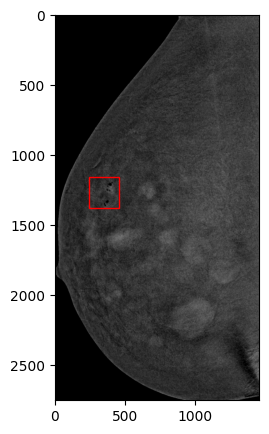

In [16]:
# plot mask and the bounding box
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(image, cmap='gray')
x,y,w,h = bbox_from_mask(mask)
rect = plt.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

# Check bbox annotations

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

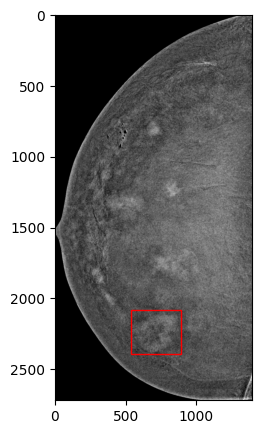

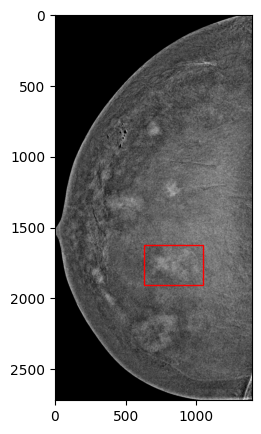

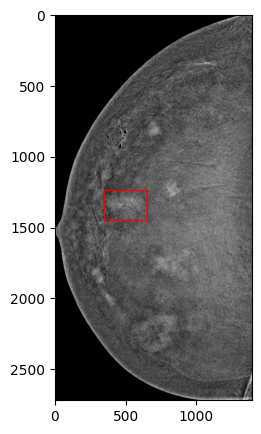

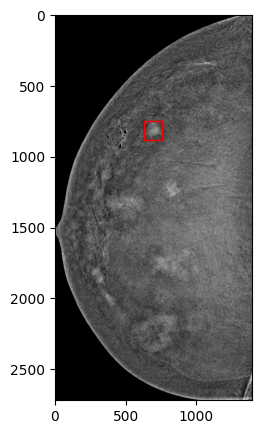

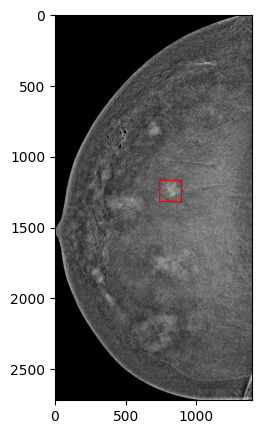

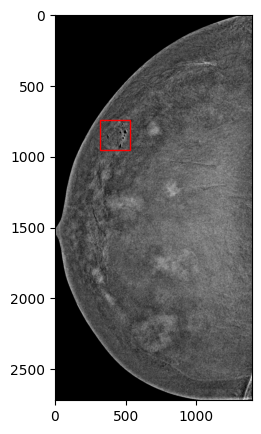

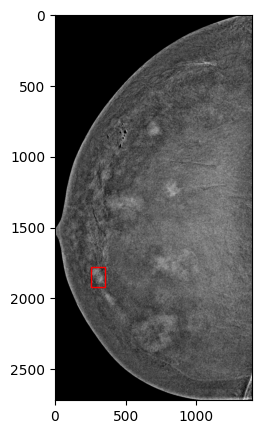

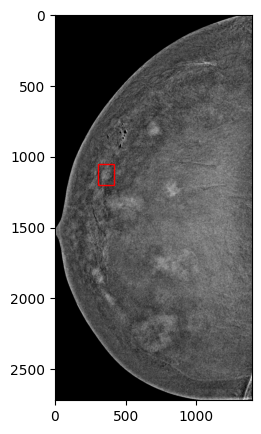

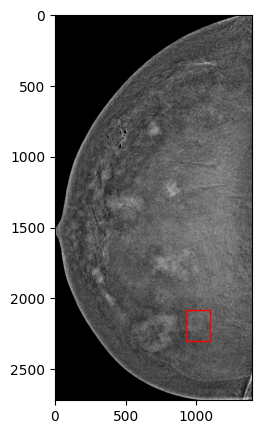

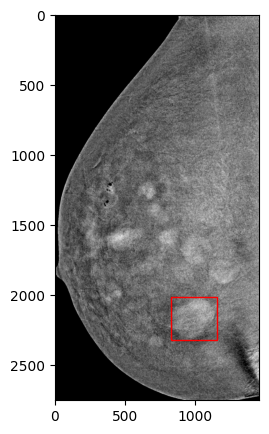

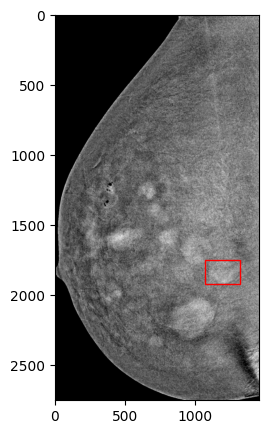

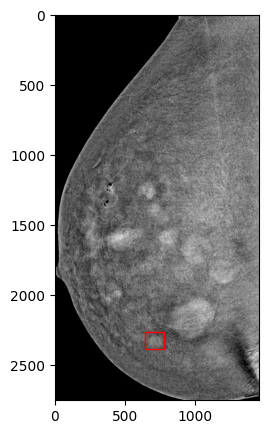

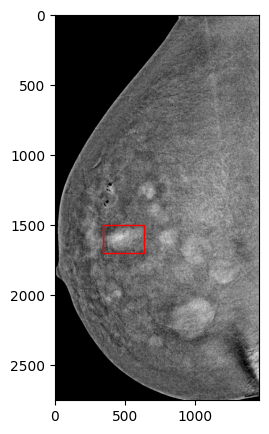

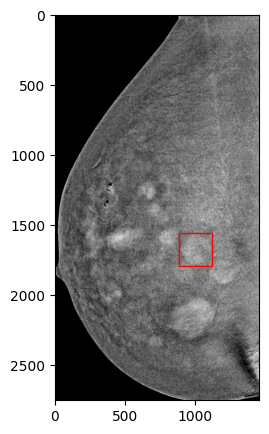

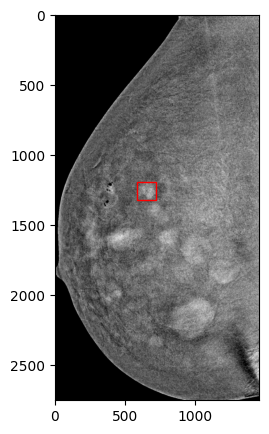

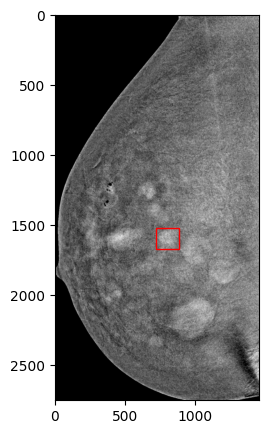

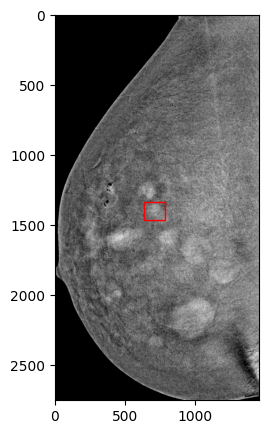

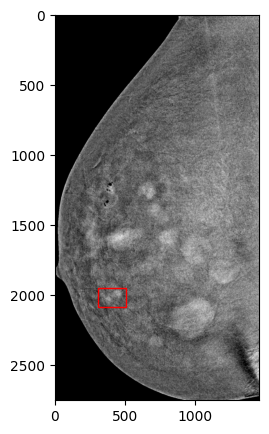

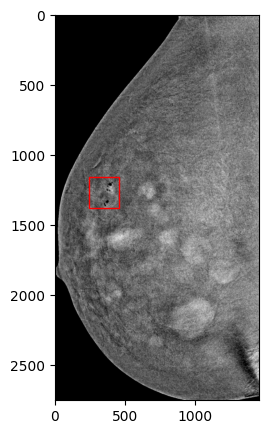

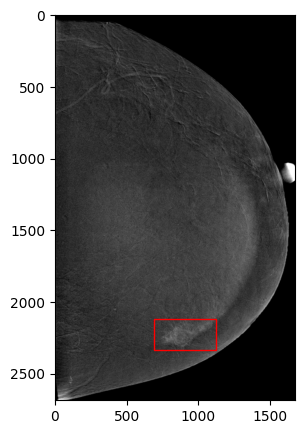

In [22]:
# read bbox from the dataframe
bbox_dataframe = pd.read_csv(repo_path / 'data/CDD-CESM/masks/bbox_CESM.csv')
# get first row
break_counter = 0
for row in bbox_dataframe.iterrows():
    row = row[1]
    im_name = row['image_name']
    region_id = row['region_id']
    bbox = eval(row['bbox'])

    substracted_dir = repo_path / 'data/CDD-CESM/images/substracted'
    # read image
    im_path = substracted_dir / f'{im_name}.jpg'
    im_array = cv.imread(str(im_path), cv.IMREAD_GRAYSCALE)
    # plot image and bbox
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    ax.imshow(im_array, cmap='gray')
    x,y,w,h = bbox
    rect = plt.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
    break_counter+=1
    if break_counter==20:
        break